In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Bidirectional, LSTM, ConvLSTM2D, TimeDistributed
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

In [ ]:
!unzip "/content/drive/MyDrive/Dataset/big_dataset.zip" -d "/content/dataset"

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/dataset/Normal/Normal-5499.png  
  inflating: /content/dataset/Normal/Normal-55.png  
  inflating: /content/dataset/Normal/Normal-550.png  
  inflating: /content/dataset/Normal/Normal-5500.png  
  inflating: /content/dataset/Normal/Normal-5501.png  
  inflating: /content/dataset/Normal/Normal-5502.png  
  inflating: /content/dataset/Normal/Normal-5503.png  
  inflating: /content/dataset/Normal/Normal-5504.png  
  inflating: /content/dataset/Normal/Normal-5505.png  
  inflating: /content/dataset/Normal/Normal-5506.png  
  inflating: /content/dataset/Normal/Normal-5507.png  
  inflating: /content/dataset/Normal/Normal-5508.png  
  inflating: /content/dataset/Normal/Normal-5509.png  
  inflating: /content/dataset/Normal/Normal-551.png  
  inflating: /content/dataset/Normal/Normal-5510.png  
  inflating: /content/dataset/Normal/Normal-5511.png  
  inflating: /content/dataset/Normal/Normal-5512.png  
  inflatin

In [ ]:
data_dir = '/content/dataset'
img_height = 224
img_width = 224
batch_size=16

train_datagen = ImageDataGenerator(
    #  rotation_range=30, 
    #  width_shift_range=0.2,
    #  height_shift_range=0.2, 
    #  brightness_range=[0.5,1.5],  
    #  zoom_range=0.2,
    #  horizontal_flip=True, 
    rescale=1/255,
    preprocessing_function=None, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None
)

train_gen=train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_gen=train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


#Build Arsitektur

##VGG19

In [ ]:
model_vgg = Sequential(VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_vgg.add(Flatten())
model_vgg.add(Dense(128, activation='tanh'))
model_vgg.add(Dense(512, activation='tanh'))
model_vgg.add(Dropout(rate=0.2))
model_vgg.add(Dense(3, activation='softmax'))

##VGG19 + BiLSTM

In [ ]:
model_vggbilstm = Sequential(VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_vggbilstm.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_vggbilstm.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_vggbilstm.add(Dropout(0.5))
model_vggbilstm.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_vggbilstm.add(Dropout(0.5))
model_vggbilstm.add(Dense(128, activation='tanh'))
model_vggbilstm.add(Dropout(0.5))
model_vggbilstm.add(Dense(3, activation='softmax'))

## ResNET50

In [ ]:
model_resnet = Sequential(ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_resnet.add(Flatten())
model_resnet.add(Dense(128, activation='tanh'))
model_resnet.add(Dropout(rate=0.5))
model_resnet.add(Dense(3, activation='softmax'))

94781440/94765736 [==============================] - 0s 0us/step


## ResNet50+BiLSTM

In [ ]:
model_resnetbilstm = Sequential(ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_resnetbilstm.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_resnetbilstm.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_resnetbilstm.add(Dropout(0.5))
model_resnetbilstm.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_resnetbilstm.add(Dropout(0.5))
model_resnetbilstm.add(Dense(128, activation='tanh'))
model_resnetbilstm.add(Dropout(0.5))
model_resnetbilstm.add(Dense(3, activation='softmax'))

##InceptionV3+BiLSTM

In [ ]:
model_inception = Sequential(InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_inception.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_inception.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_inception.add(Dropout(0.5))
model_inception.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(128, activation='tanh'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(3, activation='softmax'))

##XCeption+BiLSTM

In [ ]:
model_xception = Sequential(Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_xception.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_xception.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_xception.add(Dropout(0.5))
model_xception.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(128, activation='tanh'))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(3, activation='softmax'))

#Training Part

In [ ]:
model_vggbilstm.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 time_distributed_13 (TimeDi  (None, 7, 3584)          0         
 stributed)                                                      
                                                                 
 bidirectional_23 (Bidirecti  (None, 7, 256)           3802112   
 onal)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 7, 256)            0         
                                                                 
 bidirectional_24 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                     

In [ ]:
 model_vggbilstm.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_vggbilstm.fit(train_gen,
                    # steps_per_epoch = train_gen.samples // batch_size,
                    epochs=10, 
                    verbose=1, 
                    validation_data=valid_gen,
                    validation_steps = valid_gen.samples // batch_size)

Epoch 1/10
758/758 [==============================] - 230s 296ms/step - loss: 0.3788 - accuracy: 0.8528 - val_loss: 0.1800 - val_accuracy: 0.9385
Epoch 2/10
758/758 [==============================] - 223s 294ms/step - loss: 0.1574 - accuracy: 0.9456 - val_loss: 0.1545 - val_accuracy: 0.9471
Epoch 3/10
758/758 [==============================] - 223s 294ms/step - loss: 0.1085 - accuracy: 0.9635 - val_loss: 0.1083 - val_accuracy: 0.9633
Epoch 4/10
758/758 [==============================] - 223s 295ms/step - loss: 0.0789 - accuracy: 0.9750 - val_loss: 0.0943 - val_accuracy: 0.9732
Epoch 5/10
758/758 [==============================] - 223s 294ms/step - loss: 0.0507 - accuracy: 0.9840 - val_loss: 0.0944 - val_accuracy: 0.9726
Epoch 6/10
758/758 [==============================] - 223s 294ms/step - loss: 0.0676 - accuracy: 0.9784 - val_loss: 0.0946 - val_accuracy: 0.9709
Epoch 7/10
758/758 [==============================] - 223s 294ms/step - loss: 0.0410 - accuracy: 0.9862 - val_loss: 0.1193 -

In [ ]:
model_vggbilstm.evaluate(valid_gen)

190/190 [==============================] - 19s 98ms/step - loss: 0.0758 - accuracy: 0.9782


[0.07577350735664368, 0.9782178401947021]

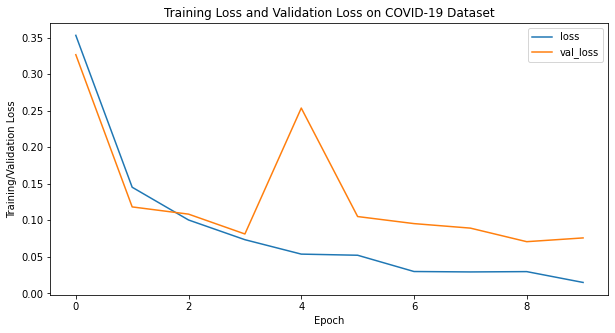

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

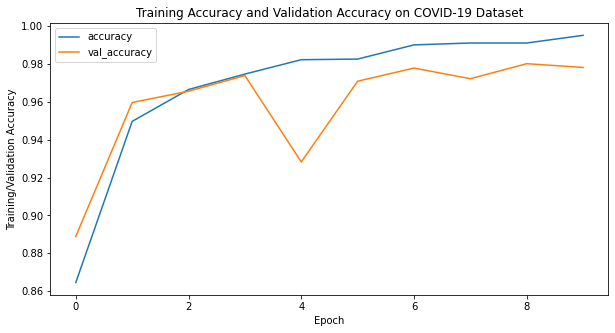

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize = (10, 5))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

In [ ]:
output_class = 3
target_names = ['COVID','Normal','Viral Pneumonia']

predict = model_vggbilstm.predict(valid_gen)
classes_x=np.argmax(predict,axis=1)

print("Confusion Matrix")
cm = confusion_matrix(valid_gen.classes, classes_x)
print(cm)
    
# show the accuracy, sensitivity, and specificity  
total = sum(sum(cm))  
if output_class == 2:
    acc = (cm[0][0] + cm[1][1]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
elif output_class == 3:
    acc = (cm[0][0] + cm[1][1] + cm[2][2]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
    sensitivity = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print("{} sensitivity: {:.4f}".format(target_names[2], sensitivity))
elif output_class == 4:
    acc = (cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2] + cm[0][3])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2] + cm[1][3])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
    sensitivity = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2] + cm[2][3])
    print("{} sensitivity: {:.4f}".format(target_names[2], sensitivity))
    sensitivity = cm[3][3] / (cm[3][0] + cm[3][1] + cm[3][2] + cm[3][3])
    print("{} sensitivity: {:.4f}".format(target_names[3], sensitivity))
else:
    print("Undefined")

print("Classification Report")
if output_class == 2:
    print(classification_report(valid_gen.classes, classes_x, target_names = target_names))
elif output_class == 3:
    print(classification_report(valid_gen.classes, classes_x, target_names = target_names))
elif output_class == 4:
    print(classification_report(valid_gen.classes, classes_x, target_names = target_names))
else:
    print("Undefined")

Confusion Matrix
[[ 688   34    1]
 [  13 2013   12]
 [   0    6  263]]
acc: 0.9782
COVID sensitivity: 0.9516
Normal sensitivity: 0.9877
Viral Pneumonia sensitivity: 0.9777
Classification Report
                 precision    recall  f1-score   support

          COVID       0.98      0.95      0.97       723
         Normal       0.98      0.99      0.98      2038
Viral Pneumonia       0.95      0.98      0.97       269

       accuracy                           0.98      3030
      macro avg       0.97      0.97      0.97      3030
   weighted avg       0.98      0.98      0.98      3030



#Simpan Model

In [ ]:
model_vggbilstm.save('/content/drive/MyDrive/model/model_vgg.h5')

In [ ]:
model_resnetbilstm.save('/content/drive/MyDrive/model/model_resnet.h5')

In [ ]:
model_inception.save('/content/drive/MyDrive/model/model_inception.h5')

In [ ]:
model_xception.save('/content/drive/MyDrive/model/model_xception.h5')